In [1]:
#! pip3 install virtualenv
!pip3 install --user ipykernel


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [5]:
! python -m ipykernel install --user --name=mychurn

/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: No module named ipykernel


In [6]:
#! pip install seaborn
! pip install tensorflow


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [7]:
! pip install imblearn


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import json

SEED = 42
np.random.seed(SEED)

2022-12-30 23:56:12.070592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [189]:
df = pd.read_csv("./data/bank_data_train.csv")
test = pd.read_csv("./data/bank_data_test.csv")
print(f'Размерность данных:\n\ttrain: {df.shape} \n\ttest: {test.shape}')
df.head()

Размерность данных:
	train: (355190, 116) 
	test: (88798, 116)


,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,...,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,146842,0,0.041033,NaN,NaN,NaN,NaN,0.0,0.166667,0.186107,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
2,146843,0,0.006915,0.0,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
3,146844,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
4,146845,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0


In [190]:
df['TARGET'].value_counts()

0    326265
1     28925
Name: TARGET, dtype: int64

In [11]:
df.columns

Index(['ID', 'CR_PROD_CNT_IL', 'AMOUNT_RUB_CLO_PRC',
       'PRC_ACCEPTS_A_EMAIL_LINK', 'APP_REGISTR_RGN_CODE', 'PRC_ACCEPTS_A_POS',
       'PRC_ACCEPTS_A_TK', 'TURNOVER_DYNAMIC_IL_1M', 'CNT_TRAN_AUT_TENDENCY1M',
       'SUM_TRAN_AUT_TENDENCY1M',
       ...
       'REST_DYNAMIC_CC_3M', 'MED_DEBT_PRC_YWZ', 'LDEAL_ACT_DAYS_PCT_TR3',
       'LDEAL_ACT_DAYS_PCT_AAVG', 'LDEAL_DELINQ_PER_MAXYWZ',
       'TURNOVER_DYNAMIC_CC_3M', 'LDEAL_ACT_DAYS_PCT_TR',
       'LDEAL_ACT_DAYS_PCT_TR4', 'LDEAL_ACT_DAYS_PCT_CURR', 'TARGET'],
      dtype='object', length=116)

## Обработка

### Работа с пропусками 

#### План
Посмотрим на наши данные с пропусками и определим какие серии мы будем рассматривать, а какие просто дропнем
1. Посчитаем количество пропусков в каждой серии 
2. Посмотрим на распределение (увидим два горба и просто осечем все что больше точки перегиба)

#### 1. Считаем пропуски

In [12]:
count_nulls = df.isnull().sum()
count_nulls

ID                               0
CR_PROD_CNT_IL                   0
AMOUNT_RUB_CLO_PRC           38323
PRC_ACCEPTS_A_EMAIL_LINK    200027
APP_REGISTR_RGN_CODE        294640
                             ...  
TURNOVER_DYNAMIC_CC_3M           0
LDEAL_ACT_DAYS_PCT_TR       261742
LDEAL_ACT_DAYS_PCT_TR4      261742
LDEAL_ACT_DAYS_PCT_CURR     261742
TARGET                           0
Length: 116, dtype: int64

Точку перегиба искал руками просто подбором используя плотность распределния `stats.gaussian_kde(null_counts).pdf(100500)`

In [14]:
threshold = 155400 #155400 # тут +/- точка перегиба

#### 2. Строим график

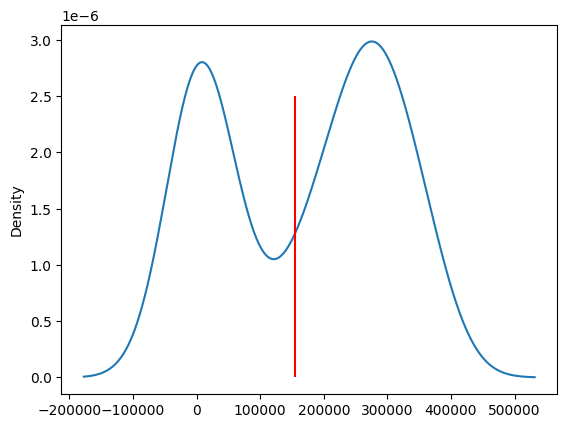

In [15]:
count_nulls.plot.kde()
plt.vlines(threshold, 0, 2.5e-06, color = 'r')
plt.show()

#### 3. Дропаем все что больше порога

In [16]:
not_null_columns = count_nulls[count_nulls < threshold].index

In [17]:
df_drop = df[not_null_columns]
df_drop.shape

(355190, 49)

### Работа с типами данных

#### План
1. Посмотреть на типы данных
2. Если есть типы данных отличные от численных, попробовать закодировать

In [20]:
df_drop_factorize = df_drop.copy()

In [25]:
x = df_drop_factorize.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355190 entries, 0 to 355189
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        355190 non-null  int64  
 1   CR_PROD_CNT_IL            355190 non-null  int64  
 2   AMOUNT_RUB_CLO_PRC        316867 non-null  float64
 3   TURNOVER_DYNAMIC_IL_1M    355190 non-null  float64
 4   AMOUNT_RUB_SUP_PRC        316867 non-null  float64
 5   REST_DYNAMIC_FDEP_1M      355190 non-null  float64
 6   REST_DYNAMIC_SAVE_3M      355190 non-null  float64
 7   CR_PROD_CNT_VCU           355190 non-null  int64  
 8   REST_AVG_CUR              355190 non-null  float64
 9   AMOUNT_RUB_NAS_PRC        316867 non-null  float64
 10  CLNT_JOB_POSITION         355190 non-null  int64  
 11  TRANS_COUNT_SUP_PRC       316867 non-null  float64
 12  TRANS_COUNT_NAS_PRC       316867 non-null  float64
 13  CR_PROD_CNT_TOVR          355190 non-null  i

У нас есть только два типа один `object` преобразуем их

In [27]:
meta = {}
cat_feat = df_drop_factorize.select_dtypes(include=['object']).columns.tolist()
for col in cat_feat:
    meta[col] = LabelEncoder()
    df_drop_factorize[col] = meta[col].fit_transform(df_drop_factorize[col].fillna('0'))

### Работа с выбросами и заполнение пустот

#### План
1. Строим гистограммы
2. Дропаем строки с выбросами
3. Все пустоты в признаках заполняем медианными значениями (тут можно поиграт)

In [34]:
df_drop_factorize.fillna(df_drop_factorize.mean(), inplace=True)

In [40]:
def myScale(df):
    for col in df.drop('TARGET', axis=1).columns:
        mean_, std_ = df[col].mean(), df[col].std()
        df[col] = (df[col] - mean_) / std_
    return df.drop(['ID', 'TARGET'], axis=1), df.TARGET, df.columns

In [41]:
df_scale, y, columns = myScale(df_drop_factorize)

### Разделяем выборку на тестовую и тренировочную ( 20% )

In [46]:
%%time
data = {}
data['X_train'], data['X_test'], data['y_train'], data['y_test'] = train_test_split(df_scale, y, test_size=0.2)

CPU times: user 173 ms, sys: 41.1 ms, total: 214 ms
Wall time: 214 ms


## Обучение моделей

### Вспомогательные функции для сбора данных

In [119]:
def myScore(data, prediction, name, config):
    result = {
        'name': name,
        'train AUC': roc_auc_score(data['y_train'], prediction[0]),
        'test AUC': roc_auc_score(data['y_test'], prediction[1]),
        'train ACC': accuracy_score(data['y_train'], (prediction[0] > 0.5).astype(int)),
        'test ACC': accuracy_score(data['y_test'], (prediction[1] > 0.5).astype(int)),
        'config': config
    }
    
    for name, val in result.items():
        print(f'{name}: {val}')
        
    return result

In [143]:
def myPredict(res_table, data, model_class, config):
    
    model = model_class(config)
    if config.get('model'):
        del config['model']
    model_name = model_class.__name__ + ': ' + json.dumps(config)
    
    model.fit(data['X_train'], data['y_train']),
    models[model_name] = model
    prediction = (
        model.predict(data['X_train']),
        model.predict(data['X_test'])
    )
    
    res_table = res_table.append(myScore(data, prediction, model_name, config), ignore_index=True)
    
    return res_table, models 

In [135]:
models = {}
res_table = pd.DataFrame(columns=['name', 'train AUC', 'test AUC', 'train ACC', 'test ACC', 'config'])
res_table

,name,train AUC,test AUC,train ACC,test ACC,config


### Обертки для моделей

#### BernoulliNB

In [150]:
class WrapperNaive:
    def __init__(self, hp):
        self.binarize = hp.get('binarize', 5)
        
    def fit(self, X, y):
        X = X.values.astype('float32')

        self.model = BernoulliNB(binarize = self.binarize)
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

#### Keras

In [121]:
class WrapperKeras:
    def __init__(self, hp):
        self.epochs = hp.get('epochs', 50)
        self.batch_size = hp.get('batch_size', 512)
        self.model = hp['model']
        
    def fit(self, X, y):
        X = X.values.astype('float32')
        y = pd.get_dummies(y).values.astype('float32')

        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
        
    def predict(self, X):
        return self.model.predict(X.values.astype('float32'))[:, 1]

#### GridSearch RandomForestClassifier

In [122]:
class WrapperRFGridSearch:
    def __init__(self, param_grid, metric = 'roc_auc'):
        self.param_grid = param_grid
        self.metric = metric
    
    def fit(self, X, y):
        gs = GridSearchCV(
            estimator=RandomForestClassifier(), 
            param_grid=self.param_grid, 
            scoring=self.metric,
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        
        gs.fit(X, y)
        self.model = gs.best_estimator_

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

#### GridSearch MLPClassifier

In [83]:
class WrapperMLPGrid:
    def __init__(self, param_grid, metric = 'roc_auc'):
        self.param_grid = param_grid
        self.metric = metric
    
    def fit(self, X, y):
        gs = GridSearchCV(
            estimator=MLPClassifier(), 
            param_grid=self.param_grid, 
            cv=5,
            verbose=1,
            n_jobs=-1,
            scoring=self.metric
        )
        gs.fit(X, y)
        
        self.model = gs.best_estimator_

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

### Конструируем модель для keras 

In [85]:
def createKerasModel(inputN):
    model = Sequential()
    model.add(Dense(40, input_shape=(inputN, ), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(45, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(65, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(45, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(45, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

### Запускаем модели

#### Baseline naive classifier

In [151]:
res_table, models = myPredict(res_table, data, WrapperNaive, {'binarize': 2})

name: WrapperNaive: {"binarize": 2}
train AUC: 0.6051795498822086
test AUC: 0.6078784411804842
train ACC: 0.8962562290605028
test ACC: 0.8971114051634337
config: {'binarize': 2}


In [153]:
res_table, models = myPredict(res_table, data, WrapperNaive, {'binarize': 5})

name: WrapperNaive: {"binarize": 5}
train AUC: 0.5331269803979012
test AUC: 0.5308977375121493
train ACC: 0.9180614600636279
test ACC: 0.9191418677327627
config: {'binarize': 5}


In [154]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperKeras: {""epochs"": 50}",0.847200,0.834682,0.919008,0.920001,{'epochs': 50}
1,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
2,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
3,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}


#### Запускаем Keras

* на 50 эпох

In [134]:
kerasModel = createKerasModel(data['X_train'].shape[1])
config = {'epochs': 50, 'model': kerasModel}

In [136]:
res_table, models = myPredict(res_table, data, WrapperKeras, config)

Epoch 1/50
555/555 [==============================] - 5s 4ms/step - loss: 0.3385
Epoch 2/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2587
Epoch 3/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2545
Epoch 4/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2505
Epoch 5/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2478
Epoch 6/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2452
Epoch 7/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2424
Epoch 8/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2404
Epoch 9/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2388
Epoch 10/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2371
Epoch 11/50
555/555 [==============================] - 2s 3ms/step - loss: 0.2355
Epoch 12/50
555/555 [==============================] - 2s 4ms/step - loss: 0.2354
Epoch 13/50
555/555 [====

* на 200 эпох

In [163]:
kerasModel = createKerasModel(data['X_train'].shape[1])
config = {'epochs': 200, 'model': kerasModel}
res_table, models = myPredict(res_table, data, WrapperKeras, config)

Epoch 1/200
555/555 [==============================] - 5s 4ms/step - loss: 0.3440
Epoch 2/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2600
Epoch 3/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2547
Epoch 4/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2511
Epoch 5/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2482
Epoch 6/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2455
Epoch 7/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2430
Epoch 8/200
555/555 [==============================] - 2s 3ms/step - loss: 0.2412
Epoch 9/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2396
Epoch 10/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2381
Epoch 11/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2369
Epoch 12/200
555/555 [==============================] - 2s 4ms/step - loss: 0.2356
Epoch 13/200


555/555 [==============================] - 3s 5ms/step - loss: 0.2220
Epoch 100/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2214
Epoch 101/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2210
Epoch 102/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2211
Epoch 103/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2220
Epoch 104/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2217
Epoch 105/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2214
Epoch 106/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2213
Epoch 107/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2211
Epoch 108/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2213
Epoch 109/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2213
Epoch 110/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2212
Epoch 

555/555 [==============================] - 3s 5ms/step - loss: 0.2192
Epoch 197/200
555/555 [==============================] - 3s 6ms/step - loss: 0.2189
Epoch 198/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2191
Epoch 199/200
555/555 [==============================] - 3s 5ms/step - loss: 0.2190
Epoch 200/200
2220/2220 [==============================] - 3s 1ms/step
name: WrapperKeras: {"epochs": 200}
train AUC: 0.8641282337001336
test AUC: 0.839245424635432
train ACC: 0.9202856217798925
test ACC: 0.919690869675385
config: {'epochs': 200}


In [164]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperKeras: {""epochs"": 50}",0.847200,0.834682,0.919008,0.920001,{'epochs': 50}
1,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
2,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
3,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
4,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
5,"WrapperKeras: {""epochs"": 200}",0.864128,0.839245,0.920286,0.919691,{'epochs': 200}


#### Запускаем Multi-layer Perceptron classifier

In [144]:
%%time
param_grid = {
    'solver': ['adam'],
    'max_iter': [50, 100], #  
    'activation': ['relu', 'logistic'], # 
    'hidden_layer_sizes': [(62, 32, 1)]
}

res_table, models = myPredict(res_table, data, WrapperMLPGrid, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py

name: WrapperMLPGrid: {"solver": ["adam"], "max_iter": [50, 100], "activation": ["relu", "logistic"], "hidden_layer_sizes": [[62, 32, 1]]}
train AUC: 0.848121174980258
test AUC: 0.8228794805156252
train ACC: 0.9192791182184183
test ACC: 0.9190010980038853
config: {'solver': ['adam'], 'max_iter': [50, 100], 'activation': ['relu', 'logistic'], 'hidden_layer_sizes': [(62, 32, 1)]}
CPU times: user 21min 59s, sys: 5min 17s, total: 27min 16s
Wall time: 15min 43s


In [165]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperKeras: {""epochs"": 50}",0.847200,0.834682,0.919008,0.920001,{'epochs': 50}
1,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
2,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
3,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
4,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
5,"WrapperKeras: {""epochs"": 200}",0.864128,0.839245,0.920286,0.919691,{'epochs': 200}


#### Запускаем RandomForestClassifier

In [155]:
%%time

param_grid = {
    'n_estimators': [200], # количество деревьев в лесу
    'max_features': ['sqrt'], #  размер случайных подмножеств функций, которые следует учитывать при разделении узла
    'max_depth': [32], # максимальная глубина дерева
    'criterion': ['entropy'], # функция измерения качества разделения
}

res_table, models = myPredict(res_table, data, WrapperRFGridSearch, param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
name: WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}
train AUC: 0.9999939244342466
test AUC: 0.8419617285310099
train ACC: 0.9975822799065289
test ACC: 0.9203947183197725
config: {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth': [32], 'criterion': ['entropy']}
CPU times: user 5min 10s, sys: 3.21 s, total: 5min 14s
Wall time: 13min 2s


In [156]:
res_table

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperKeras: {""epochs"": 50}",0.847200,0.834682,0.919008,0.920001,{'epochs': 50}
1,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
2,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
3,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
4,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."


### Делаем микс моделей чтобы достичь `0.85`

In [157]:
def compositionModel(composition_models, weights):
    pred = 0
    for i in range(len(composition_models)):
        model = composition_models[i]
        weight = weights[i]
        print(model, pred)
        pred += model.predict(data['X_test']) * weight
    print(roc_auc_score(data['y_test'], pred / len(composition_models)))

In [195]:
models

{'WrapperKeras: {"epochs": 50}': <__main__.WrapperKeras at 0x173396320>,
 'WrapperMLPGrid: {"solver": ["adam"], "max_iter": [50, 100], "activation": ["relu", "logistic"], "hidden_layer_sizes": [[62, 32, 1]]}': <__main__.WrapperMLPGrid at 0x16f15f5b0>,
 'WrapperNaive: {"binarize": 2}': <__main__.WrapperNaive at 0x16f20eef0>,
 'WrapperNaive: {"binarize": 5}': <__main__.WrapperNaive at 0x16f20f460>,
 'WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}': <__main__.WrapperRFGridSearch at 0x16f20fdf0>,
 'WrapperKeras: {"epochs": 200}': <__main__.WrapperKeras at 0x172a2e830>}

In [200]:
keras = models['WrapperKeras: {"epochs": 200}']
rf200 = models['WrapperRFGridSearch: {"n_estimators": [200], "max_features": ["sqrt"], "max_depth": [32], "criterion": ["entropy"]}']
mlp = models['WrapperNaive: {"binarize": 5}']

In [205]:
compositionModel([keras, rf200], [0.8, 1])

<__main__.WrapperKeras object at 0x172a2e830> 0
2220/2220 [==============================] - 2s 1ms/step
<__main__.WrapperRFGridSearch object at 0x16f20fdf0> [0.0251648  0.18629299 0.0174642  ... 0.08519899 0.14997767 0.2617565 ]
0.849655679533629


In [183]:
0.8496885397739082
0.8496878457694848

models_model = {}
for key in models:
    if('MLPClassifier' not in key):
        models_model[key] = models[key].model

## Сохранение результатов

In [185]:
joblib.dump(models_model, 'save/models_ai.pkl')
joblib.dump(data, 'save/data_ai.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dropout
.........vars
...metrics
......mean
.........vars
............0
............1
...optimiz

['save/data_ai.pkl']

In [187]:
res_table.s

,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperKeras: {""epochs"": 50}",0.847200,0.834682,0.919008,0.920001,{'epochs': 50}
1,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
2,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
3,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
4,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
5,"WrapperKeras: {""epochs"": 200}",0.864128,0.839245,0.920286,0.919691,{'epochs': 200}


### TensorFlow

In [216]:
TFModel = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(data['X_train'].shape[1], ), activation='relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
TFModel.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
            metrics=tf.keras.metrics.AUC())
TFHistory = TFModel.fit(data['X_train'], data['y_train'], batch_size=512, epochs=10, verbose=1)

Epoch 1/10
555/555 [==============================] - 2s 2ms/step - loss: 0.2857 - auc_4: 0.6070
Epoch 2/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2707 - auc_4: 0.6678
Epoch 3/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2679 - auc_4: 0.6809
Epoch 4/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2671 - auc_4: 0.6896
Epoch 5/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2650 - auc_4: 0.6980
Epoch 6/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2634 - auc_4: 0.7024
Epoch 7/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2638 - auc_4: 0.6991
Epoch 8/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2638 - auc_4: 0.7015
Epoch 9/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2631 - auc_4: 0.7046
Epoch 10/10
555/555 [==============================] - 1s 2ms/step - loss: 0.2635 - auc_4: 0.7033


In [230]:
tf_y_predict = TFModel.predict(data['X_test'])
tf_y_predict_class = (tf_y_predict >= 0.5).astype(int)

res_table.append({
    'name': 'TF', 
    'train AUC': 0, 
    'test ACC' : accuracy_score(data['y_test'], tf_y_predict_class),
    'train ACC': 0,
    'test AUC': roc_auc_score(data['y_test'], tf_y_predict),
    'config': 'null'
}, ignore_index=True)

2220/2220 [==============================] - 1s 628us/step


,name,train AUC,test AUC,train ACC,test ACC,config
0,"WrapperKeras: {""epochs"": 50}",0.847200,0.834682,0.919008,0.920001,{'epochs': 50}
1,"WrapperMLPGrid: {""solver"": [""adam""], ""max_iter...",0.848121,0.822879,0.919279,0.919001,"{'solver': ['adam'], 'max_iter': [50, 100], 'a..."
2,"WrapperNaive: {""binarize"": 2}",0.605180,0.607878,0.896256,0.897111,{'binarize': 2}
3,"WrapperNaive: {""binarize"": 5}",0.533127,0.530898,0.918061,0.919142,{'binarize': 5}
4,"WrapperRFGridSearch: {""n_estimators"": [200], ""...",0.999994,0.841962,0.997582,0.920395,"{'n_estimators': [200], 'max_features': ['sqrt..."
5,"WrapperKeras: {""epochs"": 200}",0.864128,0.839245,0.920286,0.919691,{'epochs': 200}
6,TF,0.000000,0.755426,0.000000,0.919409,null


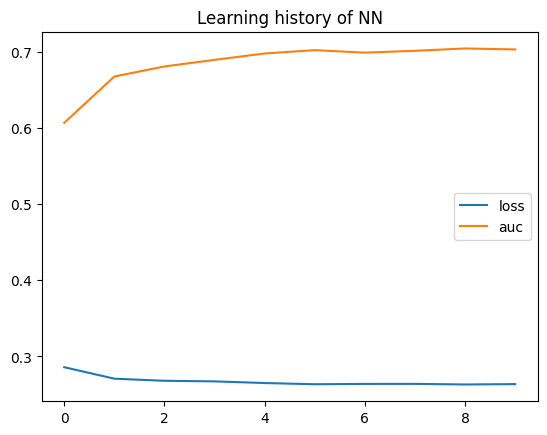

In [235]:
plt.title('Learning history of NN')
plt.plot(TFHistory.history['loss'], label='loss')
plt.plot(TFHistory.history['auc_4'], label='auc')
plt.legend()
plt.show()